<a href="https://colab.research.google.com/github/AmyTao/ImageEditingWithStableDiffusion/blob/main/Prompt_based_Image_In_Painting_powered_by_ClipSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git lfs install

Git LFS initialized.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
#! git clone https://github.com/timojl/clipseg

In [4]:
! pip install diffusers -q

In [5]:
! pip install transformers -q -UU ftfy gradio

In [6]:
! pip install git+https://github.com/openai/CLIP.git -q

  Preparing metadata (setup.py) ... done


In [7]:
from huggingface_hub import notebook_login

notebook_login()

In [8]:
%cd "/content/drive/MyDrive/Colab Notebooks/ERG4901/clipseg-master/"

/content/drive/MyDrive/Colab Notebooks/ERG4901/clipseg-master


In [9]:
!pwd

/content/drive/MyDrive/Colab Notebooks/ERG4901/clipseg-master


In [10]:
! ls

clip_masking_lvis_image_ids.yml  Quickstart.ipynb
datasets			 README.md
environment.yml			 sample_rd64.png
evaluation_utils.py		 sample_rd64_refined.png
example_image.jpg		 score.py
experiments			 setup.py
general_utils.py		 supplementary.pdf
LICENSE				 Tables.ipynb
metrics.py			 training.py
models				 Visual_Feature_Engineering.ipynb
overview.png


In [16]:
%%writefile "clipseg.py"

Writing clipseg.py


In [17]:
import sys
sys.path.append('/MyDrive/Colab Notebooks/ERG4901/clipseg-master/models/')

In [23]:
import math
from os.path import basename, dirname, join, isfile
import torch
from torch import nn
from torch.nn import functional as nnf
from torch.nn.modules.activation import ReLU


def get_prompt_list(prompt):
    if prompt == 'plain':
        return ['{}']
    elif prompt == 'fixed':
        return ['a photo of a {}.']
    elif prompt == 'shuffle':
        return ['a photo of a {}.', 'a photograph of a {}.', 'an image of a {}.', '{}.']
    elif prompt == 'shuffle+':
        return ['a photo of a {}.', 'a photograph of a {}.', 'an image of a {}.', '{}.',
                            'a cropped photo of a {}.', 'a good photo of a {}.', 'a photo of one {}.',
                            'a bad photo of a {}.', 'a photo of the {}.']
    else:
        raise ValueError('Invalid value for prompt')


def forward_multihead_attention(x, b, with_aff=False, attn_mask=None):
    """
    Simplified version of multihead attention (taken from torch source code but without tons of if clauses).
    The mlp and layer norm come from CLIP.
    x: input.
    b: multihead attention module.
    """

    x_ = b.ln_1(x)
    q, k, v = nnf.linear(x_, b.attn.in_proj_weight, b.attn.in_proj_bias).chunk(3, dim=-1)
    tgt_len, bsz, embed_dim = q.size()

    head_dim = embed_dim // b.attn.num_heads
    scaling = float(head_dim) ** -0.5

    q = q.contiguous().view(tgt_len, bsz * b.attn.num_heads, b.attn.head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, bsz * b.attn.num_heads, b.attn.head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, bsz * b.attn.num_heads, b.attn.head_dim).transpose(0, 1)

    q = q * scaling

    attn_output_weights = torch.bmm(q, k.transpose(1, 2)) #  n_heads * batch_size, tokens^2, tokens^2
    if attn_mask is not None:


        attn_mask_type, attn_mask = attn_mask
        n_heads = attn_output_weights.size(0) // attn_mask.size(0)
        attn_mask = attn_mask.repeat(n_heads, 1)

        if attn_mask_type == 'cls_token':
            # the mask only affects similarities compared to the readout-token.
            attn_output_weights[:, 0, 1:] = attn_output_weights[:, 0, 1:] * attn_mask[None,...]
            # attn_output_weights[:, 0, 0] = 0*attn_output_weights[:, 0, 0]

        if attn_mask_type == 'all':
            # print(attn_output_weights.shape, attn_mask[:, None].shape)
            attn_output_weights[:, 1:, 1:] = attn_output_weights[:, 1:, 1:] * attn_mask[:, None]


    attn_output_weights = torch.softmax(attn_output_weights, dim=-1)

    attn_output = torch.bmm(attn_output_weights, v)
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output = b.attn.out_proj(attn_output)

    x = x + attn_output
    x = x + b.mlp(b.ln_2(x))

    if with_aff:
        return x, attn_output_weights
    else:
        return x


class CLIPDenseBase(nn.Module):

    def __init__(self, version, reduce_cond, reduce_dim, prompt, n_tokens):
        super().__init__()

        import clip

        # prec = torch.FloatTensor
        self.clip_model, _ = clip.load(version, device='cpu', jit=False)
        self.model = self.clip_model.visual

        # if not None, scale conv weights such that we obtain n_tokens.
        self.n_tokens = n_tokens

        for p in self.clip_model.parameters():
            p.requires_grad_(False)

        # conditional
        if reduce_cond is not None:
            self.reduce_cond = nn.Linear(512, reduce_cond)
            for p in self.reduce_cond.parameters():
                p.requires_grad_(False)
        else:
            self.reduce_cond = None

        self.film_mul = nn.Linear(512 if reduce_cond is None else reduce_cond, reduce_dim)
        self.film_add = nn.Linear(512 if reduce_cond is None else reduce_cond, reduce_dim)

        self.reduce = nn.Linear(768, reduce_dim)

        self.prompt_list = get_prompt_list(prompt)

        # precomputed prompts
        import pickle
        if isfile('precomputed_prompt_vectors.pickle'):
            precomp = pickle.load(open('precomputed_prompt_vectors.pickle', 'rb'))
            self.precomputed_prompts = {k: torch.from_numpy(v) for k, v in precomp.items()}
        else:
            self.precomputed_prompts = dict()

    def rescaled_pos_emb(self, new_size):
        assert len(new_size) == 2

        a = self.model.positional_embedding[1:].T.view(1, 768, *self.token_shape)
        b = nnf.interpolate(a, new_size, mode='bicubic', align_corners=False).squeeze(0).view(768, new_size[0]*new_size[1]).T
        return torch.cat([self.model.positional_embedding[:1], b])

    def visual_forward(self, x_inp, extract_layers=(), skip=False, mask=None):


        with torch.no_grad():

            inp_size = x_inp.shape[2:]

            if self.n_tokens is not None:
                stride2 = x_inp.shape[2] // self.n_tokens
                conv_weight2 = nnf.interpolate(self.model.conv1.weight, (stride2, stride2), mode='bilinear', align_corners=True)
                x = nnf.conv2d(x_inp, conv_weight2, bias=self.model.conv1.bias, stride=stride2, dilation=self.model.conv1.dilation)
            else:
                x = self.model.conv1(x_inp)  # shape = [*, width, grid, grid]

            x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
            x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

            x = torch.cat([self.model.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]

            standard_n_tokens = 50 if self.model.conv1.kernel_size[0] == 32 else 197

            if x.shape[1] != standard_n_tokens:
                new_shape = int(math.sqrt(x.shape[1]-1))
                x = x + self.rescaled_pos_emb((new_shape, new_shape)).to(x.dtype)[None,:,:]
            else:
                x = x + self.model.positional_embedding.to(x.dtype)

            x = self.model.ln_pre(x)

            x = x.permute(1, 0, 2)  # NLD -> LND

            activations, affinities = [], []
            for i, res_block in enumerate(self.model.transformer.resblocks):

                if mask is not None:
                    mask_layer, mask_type, mask_tensor = mask
                    if mask_layer == i or mask_layer == 'all':
                        # import ipdb; ipdb.set_trace()
                        size = int(math.sqrt(x.shape[0] - 1))

                        attn_mask = (mask_type, nnf.interpolate(mask_tensor.unsqueeze(1).float(), (size, size)).view(mask_tensor.shape[0], size * size))

                    else:
                        attn_mask = None
                else:
                    attn_mask = None

                x, aff_per_head = forward_multihead_attention(x, res_block, with_aff=True, attn_mask=attn_mask)

                if i in extract_layers:
                    affinities += [aff_per_head]

                    #if self.n_tokens is not None:
                    #    activations += [nnf.interpolate(x, inp_size, mode='bilinear', align_corners=True)]
                    #else:
                    activations += [x]

                if len(extract_layers) > 0 and i == max(extract_layers) and skip:
                    print('early skip')
                    break

            x = x.permute(1, 0, 2)  # LND -> NLD
            x = self.model.ln_post(x[:, 0, :])

            if self.model.proj is not None:
                x = x @ self.model.proj

            return x, activations, affinities

    def sample_prompts(self, words, prompt_list=None):

        prompt_list = prompt_list if prompt_list is not None else self.prompt_list

        prompt_indices = torch.multinomial(torch.ones(len(prompt_list)), len(words), replacement=True)
        prompts = [prompt_list[i] for i in prompt_indices]
        return [promt.format(w) for promt, w in zip(prompts, words)]

    def get_cond_vec(self, conditional, batch_size):
        # compute conditional from a single string
        if conditional is not None and type(conditional) == str:
            cond = self.compute_conditional(conditional)
            cond = cond.repeat(batch_size, 1)

        # compute conditional from string list/tuple
        elif conditional is not None and type(conditional) in {list, tuple} and type(conditional[0]) == str:
            assert len(conditional) == batch_size
            cond = self.compute_conditional(conditional)

        # use conditional directly
        elif conditional is not None and type(conditional) == torch.Tensor and conditional.ndim == 2:
            cond = conditional

        # compute conditional from image
        elif conditional is not None and type(conditional) == torch.Tensor:
            with torch.no_grad():
                cond, _, _ = self.visual_forward(conditional)
        else:
            raise ValueError('invalid conditional')
        return cond

    def compute_conditional(self, conditional):
        import clip

        dev = next(self.parameters()).device

        if type(conditional) in {list, tuple}:
            text_tokens = clip.tokenize(conditional).to(dev)
            cond = self.clip_model.encode_text(text_tokens)
        else:
            if conditional in self.precomputed_prompts:
                cond = self.precomputed_prompts[conditional].float().to(dev)
            else:
                text_tokens = clip.tokenize([conditional]).to(dev)
                cond = self.clip_model.encode_text(text_tokens)[0]

        if self.shift_vector is not None:
            return cond + self.shift_vector
        else:
            return cond


def clip_load_untrained(version):
    assert version == 'ViT-B/16'
    from clip.model import CLIP
    from clip.clip import _MODELS, _download
    model = torch.jit.load(_download(_MODELS['ViT-B/16'])).eval()
    state_dict = model.state_dict()

    vision_width = state_dict["visual.conv1.weight"].shape[0]
    vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
    vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
    grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
    image_resolution = vision_patch_size * grid_size
    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith(f"transformer.resblocks")))

    return CLIP(embed_dim, image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers)


class CLIPDensePredT(CLIPDenseBase):

    def __init__(self, version='ViT-B/32', extract_layers=(3, 6, 9), cond_layer=0, reduce_dim=128, n_heads=4, prompt='fixed',
                 extra_blocks=0, reduce_cond=None, fix_shift=False,
                 learn_trans_conv_only=False,  limit_to_clip_only=False, upsample=False,
                 add_calibration=False, rev_activations=False, trans_conv=None, n_tokens=None, complex_trans_conv=False):

        super().__init__(version, reduce_cond, reduce_dim, prompt, n_tokens)
        # device = 'cpu'

        self.extract_layers = extract_layers
        self.cond_layer = cond_layer
        self.limit_to_clip_only = limit_to_clip_only
        self.process_cond = None
        self.rev_activations = rev_activations

        depth = len(extract_layers)

        if add_calibration:
            self.calibration_conds = 1

        self.upsample_proj = nn.Conv2d(reduce_dim, 1, kernel_size=1) if upsample else None

        self.add_activation1 = True

        self.version = version

        self.token_shape = {'ViT-B/32': (7, 7), 'ViT-B/16': (14, 14)}[version]

        if fix_shift:
            # self.shift_vector = nn.Parameter(torch.load(join(dirname(basename(__file__)), 'clip_text_shift_vector.pth')), requires_grad=False)
            self.shift_vector = nn.Parameter(torch.load(join(dirname(basename(__file__)), 'shift_text_to_vis.pth')), requires_grad=False)
            # self.shift_vector = nn.Parameter(-1*torch.load(join(dirname(basename(__file__)), 'shift2.pth')), requires_grad=False)
        else:
            self.shift_vector = None

        if trans_conv is None:
            trans_conv_ks = {'ViT-B/32': (32, 32), 'ViT-B/16': (16, 16)}[version]
        else:
            # explicitly define transposed conv kernel size
            trans_conv_ks = (trans_conv, trans_conv)

        if not complex_trans_conv:
            self.trans_conv = nn.ConvTranspose2d(reduce_dim, 1, trans_conv_ks, stride=trans_conv_ks)
        else:
            assert trans_conv_ks[0] == trans_conv_ks[1]

            tp_kernels = (trans_conv_ks[0] // 4, trans_conv_ks[0] // 4)

            self.trans_conv = nn.Sequential(
                nn.Conv2d(reduce_dim, reduce_dim, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(reduce_dim, reduce_dim // 2, kernel_size=tp_kernels[0], stride=tp_kernels[0]),
                nn.ReLU(),
                nn.ConvTranspose2d(reduce_dim // 2, 1, kernel_size=tp_kernels[1], stride=tp_kernels[1]),
            )

#        self.trans_conv = nn.ConvTranspose2d(reduce_dim, 1, trans_conv_ks, stride=trans_conv_ks)

        assert len(self.extract_layers) == depth

        self.reduces = nn.ModuleList([nn.Linear(768, reduce_dim) for _ in range(depth)])
        self.blocks = nn.ModuleList([nn.TransformerEncoderLayer(d_model=reduce_dim, nhead=n_heads) for _ in range(len(self.extract_layers))])
        self.extra_blocks = nn.ModuleList([nn.TransformerEncoderLayer(d_model=reduce_dim, nhead=n_heads) for _ in range(extra_blocks)])

        # refinement and trans conv

        if learn_trans_conv_only:
            for p in self.parameters():
                p.requires_grad_(False)

            for p in self.trans_conv.parameters():
                p.requires_grad_(True)

        self.prompt_list = get_prompt_list(prompt)


    def forward(self, inp_image, conditional=None, return_features=False, mask=None):

        assert type(return_features) == bool

        inp_image = inp_image.to(self.model.positional_embedding.device)

        if mask is not None:
            raise ValueError('mask not supported')

        # x_inp = normalize(inp_image)
        x_inp = inp_image

        bs, dev = inp_image.shape[0], x_inp.device

        cond = self.get_cond_vec(conditional, bs)

        visual_q, activations, _ = self.visual_forward(x_inp, extract_layers=[0] + list(self.extract_layers))

        activation1 = activations[0]
        activations = activations[1:]

        _activations = activations[::-1] if not self.rev_activations else activations

        a = None
        for i, (activation, block, reduce) in enumerate(zip(_activations, self.blocks, self.reduces)):

            if a is not None:
                a = reduce(activation) + a
            else:
                a = reduce(activation)

            if i == self.cond_layer:
                if self.reduce_cond is not None:
                    cond = self.reduce_cond(cond)

                a = self.film_mul(cond) * a + self.film_add(cond)

            a = block(a)

        for block in self.extra_blocks:
            a = a + block(a)

        a = a[1:].permute(1, 2, 0) # rm cls token and -> BS, Feats, Tokens

        size = int(math.sqrt(a.shape[2]))

        a = a.view(bs, a.shape[1], size, size)

        a = self.trans_conv(a)

        if self.n_tokens is not None:
            a = nnf.interpolate(a, x_inp.shape[2:], mode='bilinear', align_corners=True)

        if self.upsample_proj is not None:
            a = self.upsample_proj(a)
            a = nnf.interpolate(a, x_inp.shape[2:], mode='bilinear')

        if return_features:
            return a, visual_q, cond, [activation1] + activations
        else:
            return a,



class CLIPDensePredTMasked(CLIPDensePredT):

    def __init__(self, version='ViT-B/32', extract_layers=(3, 6, 9), cond_layer=0, reduce_dim=128, n_heads=4,
                 prompt='fixed', extra_blocks=0, reduce_cond=None, fix_shift=False, learn_trans_conv_only=False,
                 refine=None, limit_to_clip_only=False, upsample=False, add_calibration=False, n_tokens=None):

        super().__init__(version=version, extract_layers=extract_layers, cond_layer=cond_layer, reduce_dim=reduce_dim,
                         n_heads=n_heads, prompt=prompt, extra_blocks=extra_blocks, reduce_cond=reduce_cond,
                         fix_shift=fix_shift, learn_trans_conv_only=learn_trans_conv_only,
                         limit_to_clip_only=limit_to_clip_only, upsample=upsample, add_calibration=add_calibration,
                         n_tokens=n_tokens)

    def visual_forward_masked(self, img_s, seg_s):
        return super().visual_forward(img_s, mask=('all', 'cls_token', seg_s))

    def forward(self, img_q, cond_or_img_s, seg_s=None, return_features=False):

        if seg_s is None:
            cond = cond_or_img_s
        else:
            img_s = cond_or_img_s

            with torch.no_grad():
                cond, _, _ = self.visual_forward_masked(img_s, seg_s)

        return super().forward(img_q, cond, return_features=return_features)



class CLIPDenseBaseline(CLIPDenseBase):

    def __init__(self, version='ViT-B/32', cond_layer=0,
                extract_layer=9, reduce_dim=128, reduce2_dim=None, prompt='fixed',
                 reduce_cond=None, limit_to_clip_only=False, n_tokens=None):

        super().__init__(version, reduce_cond, reduce_dim, prompt, n_tokens)
        device = 'cpu'

        # self.cond_layer = cond_layer
        self.extract_layer = extract_layer
        self.limit_to_clip_only = limit_to_clip_only
        self.shift_vector = None

        self.token_shape = {'ViT-B/32': (7, 7), 'ViT-B/16': (14, 14)}[version]

        assert reduce2_dim is not None

        self.reduce2 = nn.Sequential(
            nn.Linear(reduce_dim, reduce2_dim),
            nn.ReLU(),
            nn.Linear(reduce2_dim, reduce_dim)
        )

        trans_conv_ks = {'ViT-B/32': (32, 32), 'ViT-B/16': (16, 16)}[version]
        self.trans_conv = nn.ConvTranspose2d(reduce_dim, 1, trans_conv_ks, stride=trans_conv_ks)


    def forward(self, inp_image, conditional=None, return_features=False):

        inp_image = inp_image.to(self.model.positional_embedding.device)

        # x_inp = normalize(inp_image)
        x_inp = inp_image

        bs, dev = inp_image.shape[0], x_inp.device

        cond = self.get_cond_vec(conditional, bs)

        visual_q, activations, affinities = self.visual_forward(x_inp, extract_layers=[self.extract_layer])

        a = activations[0]
        a = self.reduce(a)
        a = self.film_mul(cond) * a + self.film_add(cond)

        if self.reduce2 is not None:
            a = self.reduce2(a)

        # the original model would execute a transformer block here

        a = a[1:].permute(1, 2, 0) # rm cls token and -> BS, Feats, Tokens

        size = int(math.sqrt(a.shape[2]))

        a = a.view(bs, a.shape[1], size, size)
        a = self.trans_conv(a)

        if return_features:
            return a, visual_q, cond, activations
        else:
            return a,


class CLIPSegMultiLabel(nn.Module):

    def __init__(self, model) -> None:
        super().__init__()

        from third_party.JoEm.data_loader import get_seen_idx, get_unseen_idx, VOC

        self.pascal_classes = VOC

        from models.clipseg import CLIPDensePredT
        from general_utils import load_model
        # self.clipseg = load_model('rd64-vit16-neg0.2-phrasecut', strict=False)
        self.clipseg = load_model(model, strict=False)

        self.clipseg.eval()

    def forward(self, x):

        bs = x.shape[0]
        out = torch.ones(21, bs, 352, 352).to(x.device) * -10

        for class_id, class_name in enumerate(self.pascal_classes):

            fac = 3 if class_name == 'background' else 1

            with torch.no_grad():
                pred = torch.sigmoid(self.clipseg(x, class_name)[0][:,0]) * fac

            out[class_id] += pred


        out = out.permute(1, 0, 2, 3)

        return out

        # construct output tensor



In [24]:
import torch
import requests
import cv2
#import clipseg
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

In [25]:
from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

In [33]:
#! git lfs install

In [26]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();


100%|███████████████████████████████████████| 335M/335M [00:08<00:00, 41.0MiB/s]


In [33]:
import sys
sys.path.append('/MyDrive/Colab Notebooks/ERG4901/clipseg-master/weights/')

In [34]:
!wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
!unzip -d weights -j weights.zip

--2023-09-30 05:40:32--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [      <=>           ]   9.68M  5.78MB/s    in 1.7s    

2023-09-30 05:40:35 (5.78 MB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
replace weights/rd16-uni.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [39]:
!pwd
%cd weights

/content/drive/MyDrive/Colab Notebooks/ERG4901/clipseg-master
/content/drive/MyDrive/Colab Notebooks/ERG4901/clipseg-master/weights


In [40]:
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('rd64-uni.pth', map_location=torch.device('cuda')), strict=False);


In [41]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:1007: FutureWarning: You are using a legacy checkpoint for inpainting with Stable Diffusion, therefore we are loading the <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> class instead of <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'>. For better inpainting results, we strongly suggest using Stable Diffusion's official inpainting checkpoint: https://huggingface.co/runwayml/stable-diffusion-inpainting instead or adapting your checkpoint CompVis/stable-diffusion-v1-4 to the format of https://huggingface.co/runwayml/stable-diffusion-inpainting. Note that we do not actively maintain the {StableDiffusionInpaintPipelineLegacy} class and will likely remove it in version 1.0.0.
  deprecate("StableDiffusionInpaintPipelineLegacy", "1.0.0", deprecation_message, standard_warn=False)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_inpaint_legacy.py:140: FutureWarning: The class <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> is deprecated and will be removed in v1.0.0

In [42]:
# or load from URL...
image_url = 'https://okmagazine.ge/wp-content/uploads/2021/04/00-promo-rob-pattison-1024x1024.jpg' #'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimage.tmdb.org%2Ft%2Fp%2Foriginal%2F72xYNWRTVMDiKVa6SVu6EY0S9Np.jpg' #'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png'
input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [43]:
%cd ..

/content/drive/MyDrive/Colab Notebooks/ERG4901/clipseg-master


In [44]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")

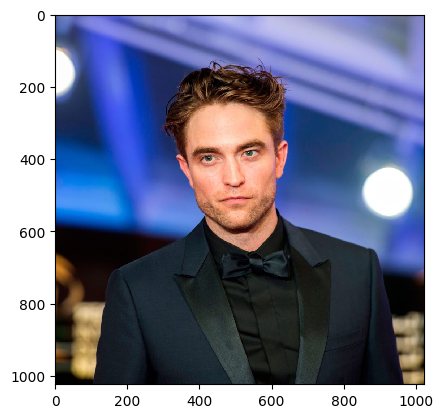

In [45]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [59]:
prompts = ['hair']

In [60]:

# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


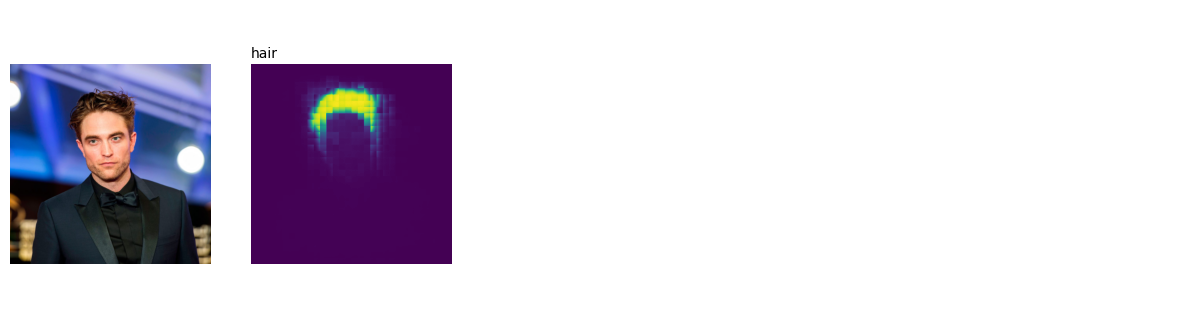

In [61]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

In [62]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

In [63]:
img2 = cv2.imread(filename)

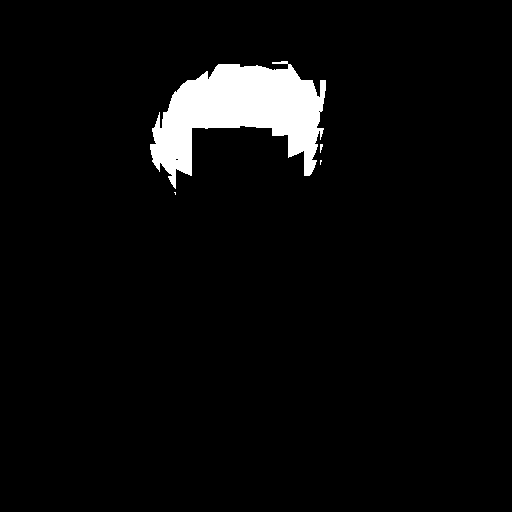

In [64]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

In [65]:
init_image = Image.open('init_image.png')
mask = Image.open('mask.png')

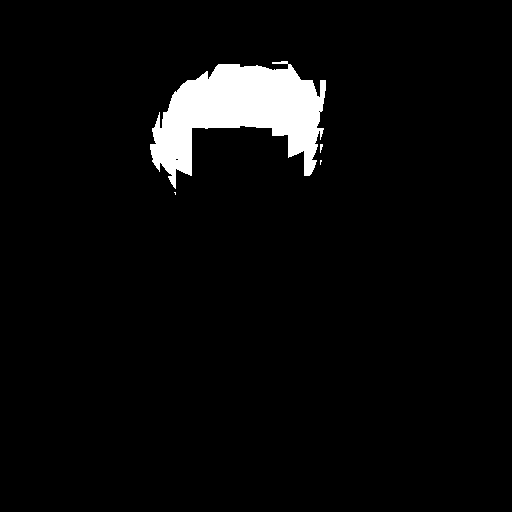

In [66]:
mask

In [67]:

with autocast("cuda"):
    images = pipe(prompt="blonde long hair", image=init_image, mask_image=mask, strength=0.8)["images"]


  0%|          | 0/40 [00:00<?, ?it/s]

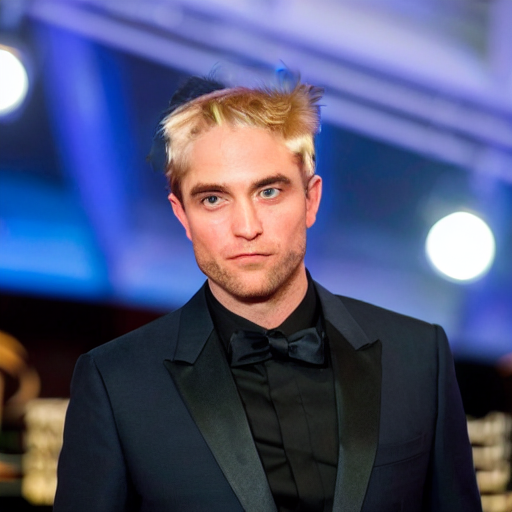

In [68]:
images[0]